In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [3]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm
!pip install pycocotools

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━

In [4]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.75

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [5]:
import os
import torchvision


# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join("/content/drive/MyDrive/dataset/", "train")
TEST_DIRECTORY = os.path.join("/content/drive/MyDrive/dataset/", "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY, 
    image_processor=image_processor, 
    train=True)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY, 
    image_processor=image_processor, 
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=6.64s)
creating index...
index created!
loading annotations into memory...
Done (t=2.25s)
creating index...
index created!
Number of training examples: 1204
Number of test examples: 300


In [6]:
import cv2
import torch
import supervision as sv


Image #381
[{'id': 652, 'image_id': 381, 'category_id': 1, 'bbox': [17, 25, 328, 435], 'area': 143115}]
{0: 'Water buffalo', 1: 'Elephant', 2: 'Rhinoceros', 3: 'Zebra'}
Detections(xyxy=array([[ 17,  25, 345, 460]]), class_id=array([1]), confidence=None, tracker_id=None)


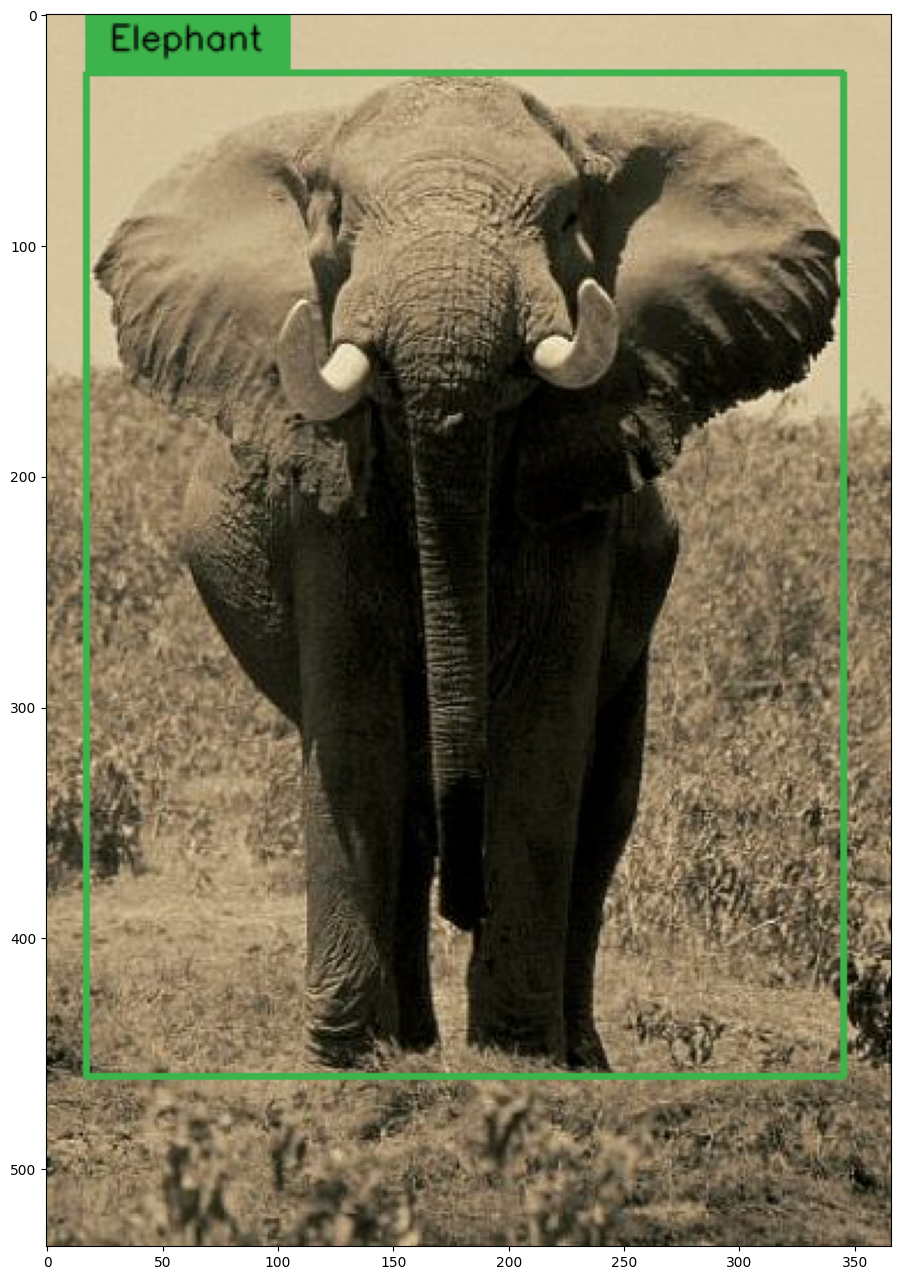

In [7]:
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
print(annotations)
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
print(id2label)
labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
print(detections)
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)
%matplotlib inline  
sv.show_frame_in_notebook(image, (16, 16))

Image #1436
/content/drive/MyDrive/dataset/test/1436.jpg
Detections(xyxy=array([[213,  70, 553, 364]]), class_id=array([0]), confidence=None, tracker_id=None)


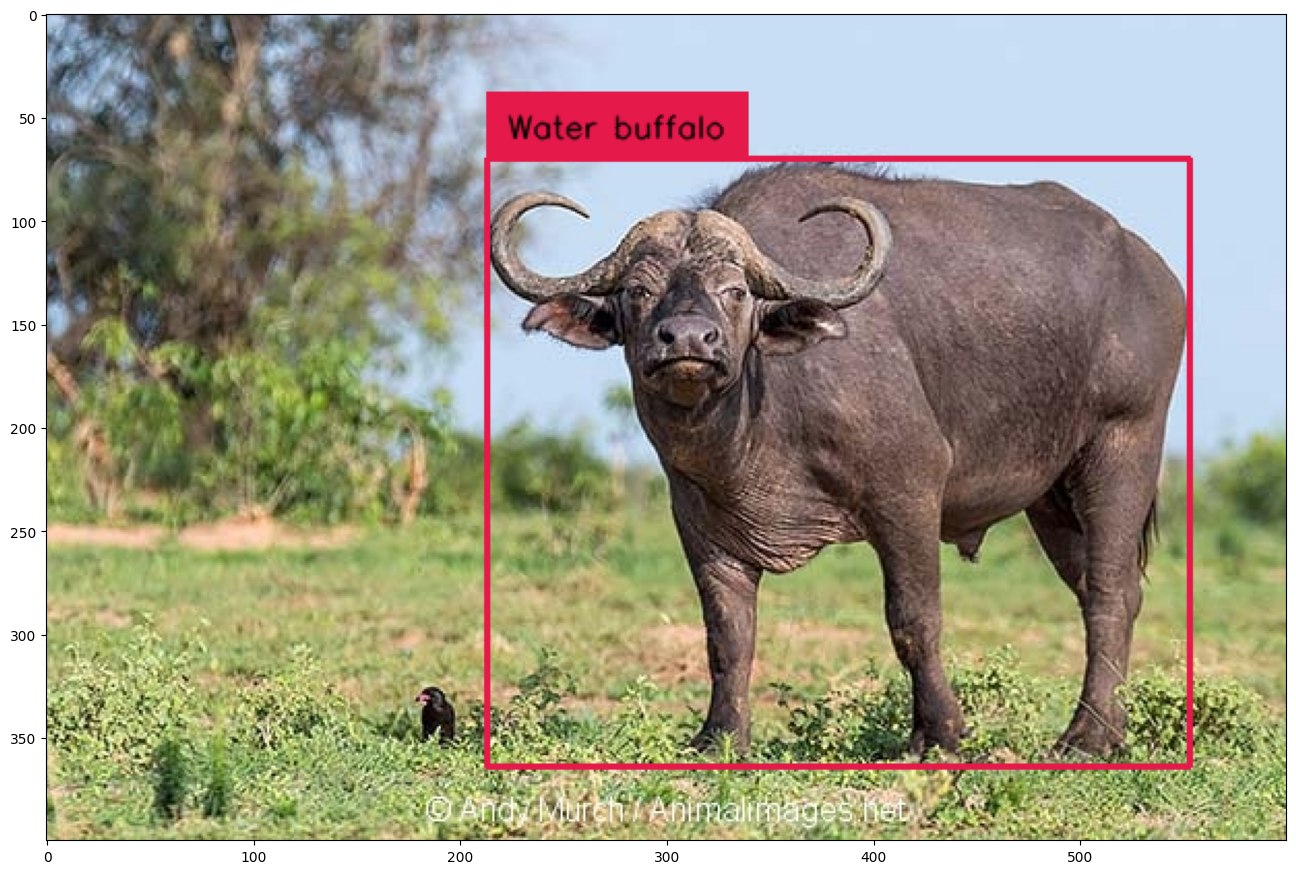

In [8]:
import random
import cv2
import numpy as np


# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
print(image_path)
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
print(detections)
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)
%matplotlib inline  
sv.show_frame_in_notebook(image, (16, 16))

In [9]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible 
    # to directly batch together images. Hence they pad the images to the biggest 
    # resolution in a given batch, and create a corresponding binary pixel_mask 
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

In [10]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

CHECKPOINT = '/content/drive/MyDrive/dataset/pytorch_model.bin'

class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            config='/content/drive/MyDrive/dataset/config.json',
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return TEST_DATALOADER

In [11]:
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
id2label

{0: 'Water buffalo', 1: 'Elephant', 2: 'Rhinoceros', 3: 'Zebra'}

In [12]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

In [13]:
outputs.logits.shape

torch.Size([4, 100, 5])

In [14]:
model.to(DEVICE)

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

Image #1291
Detections(xyxy=array([[ 32, 158, 519, 367]]), class_id=array([0]), confidence=None, tracker_id=None)
ground truth


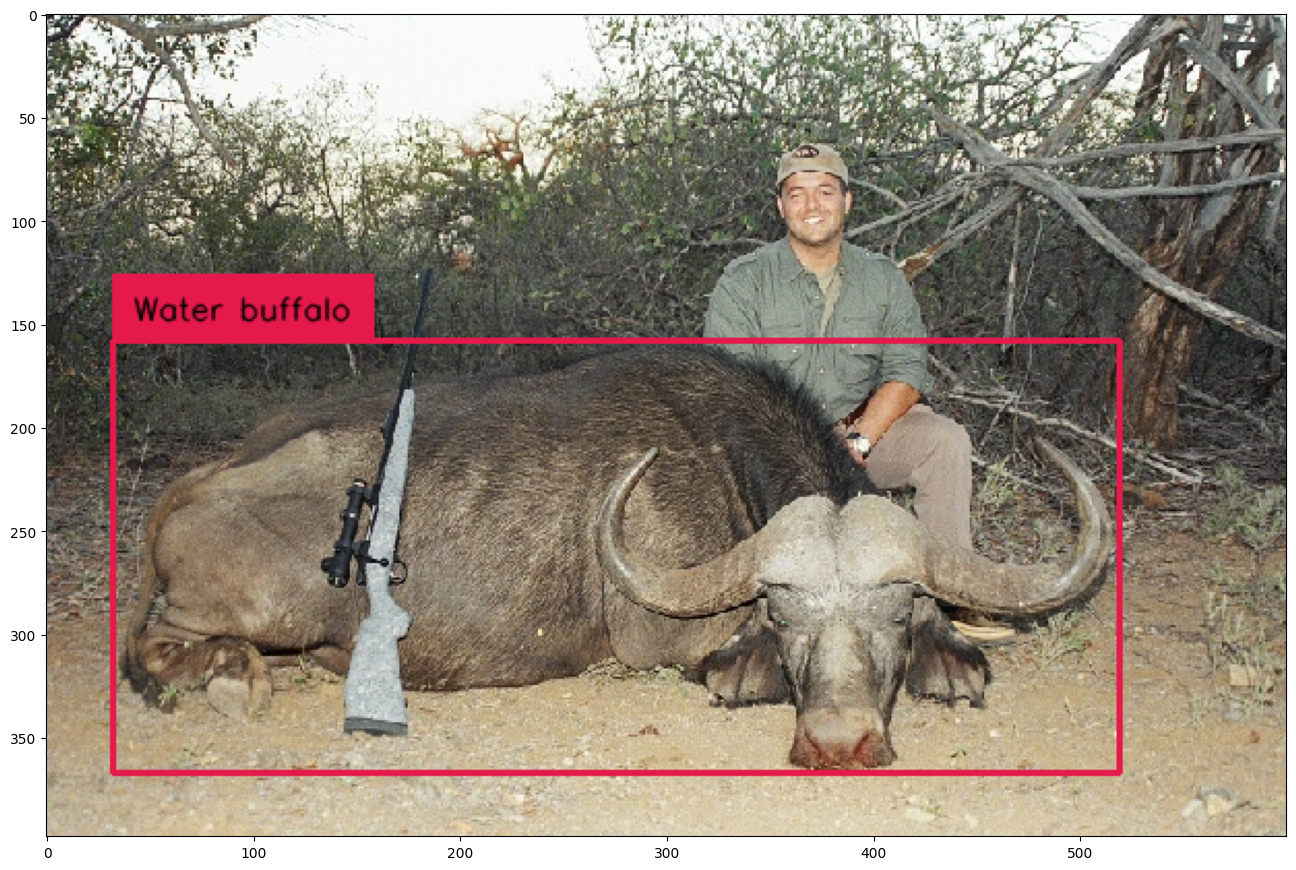

Detections(xyxy=array([[ 34.537212, 156.21803 , 513.3383  , 369.02286 ]], dtype=float32), class_id=array([2]), confidence=array([0.5747663], dtype=float32), tracker_id=None)
detections


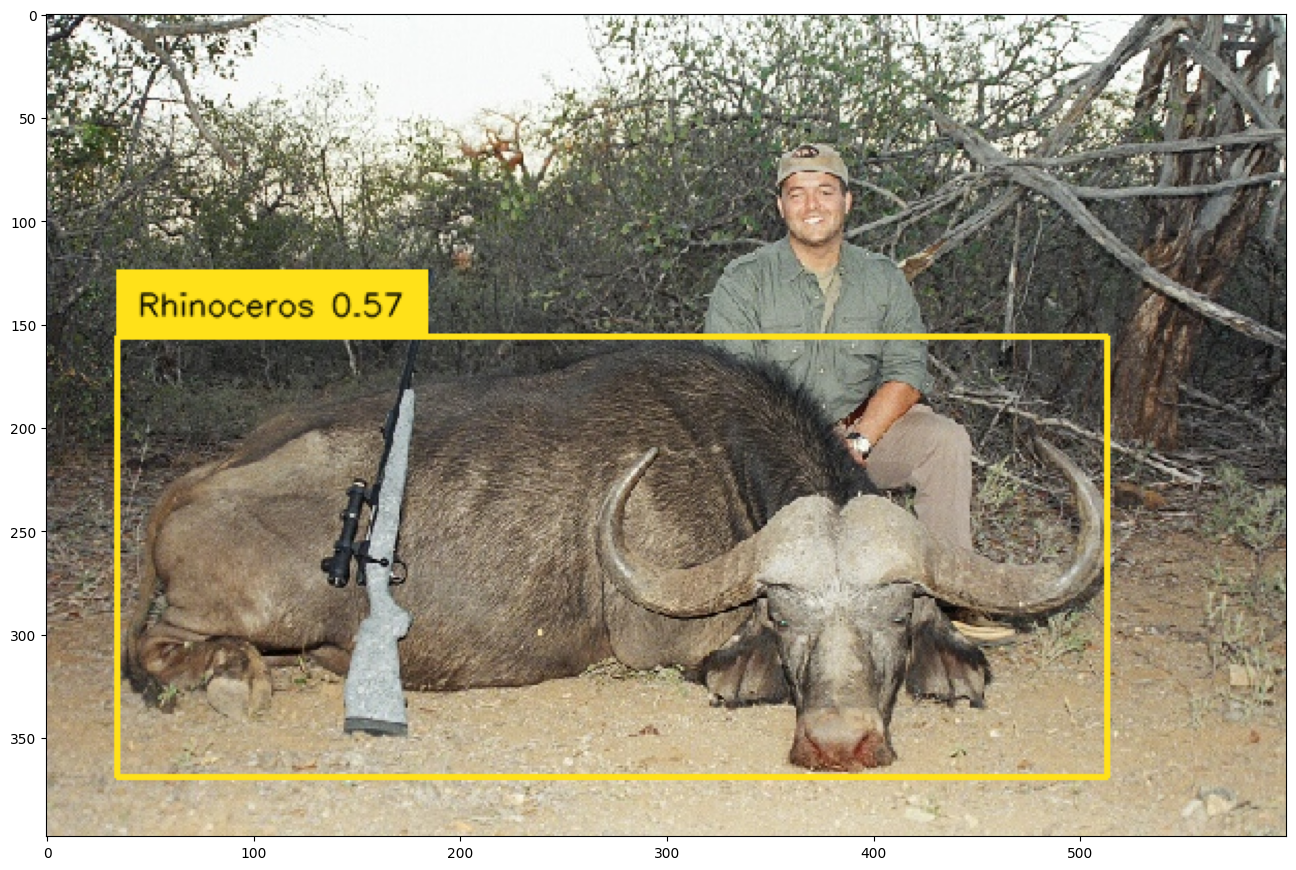

In [15]:
import random
import cv2
import numpy as np


# utils
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = TEST_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TEST_DATASET.coco.loadImgs(image_id)[0]
annotations = TEST_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TEST_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
print(detections)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('ground truth')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

# inference
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
print(detections)
labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

print('detections')
%matplotlib inline  
sv.show_frame_in_notebook(frame, (16, 16))

In [16]:
import matplotlib.pyplot as plt
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from collections import Counter

In [17]:
ground_truths = []

for tmp_image in TEST_DATASET.coco.getImgIds():
  annotations = TEST_DATASET.coco.imgToAnns[tmp_image]
  # annotate
  detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
  for idx in range(len(detections.xyxy)):
    box_info = [tmp_image, detections.class_id[idx], 1.0, detections.xyxy[idx].tolist()]
    ground_truths.append(box_info)

print(ground_truths[:10])

[[1205, 1, 1.0, [230, 75, 618, 333]], [1205, 1, 1.0, [70, 249, 196, 342]], [1205, 1, 1.0, [134, 128, 442, 322]], [1206, 3, 1.0, [332, 118, 567, 420]], [1206, 3, 1.0, [137, 85, 287, 400]], [1206, 3, 1.0, [79, 65, 227, 295]], [1206, 3, 1.0, [267, 114, 428, 385]], [1206, 3, 1.0, [252, 74, 467, 164]], [1206, 3, 1.0, [85, 42, 251, 105]], [1206, 3, 1.0, [97, 1, 163, 53]]]


In [18]:
predictions = []

with torch.no_grad():
  for tmp_image in TEST_DATASET.coco.getImgIds():
    image = TEST_DATASET.coco.loadImgs(tmp_image)[0]
    annotations = TEST_DATASET.coco.imgToAnns[tmp_image]
    image_path = os.path.join(TEST_DATASET.root, image['file_name'])
    image = cv2.imread(image_path)

    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=CONFIDENCE_TRESHOLD, 
        target_sizes=target_sizes
    )[0]

    # annotate
    print(tmp_image)
    if len(results['scores'].tolist()) ==0:
      continue
    else: 
      detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=0.5)
      for idx in range(len(detections.xyxy)):
        box_info = [tmp_image, detections.class_id[idx], detections.confidence[idx], detections.xyxy[idx].tolist()]
        predictions.append(box_info)

1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404


In [19]:
predictions[:10]

[[1205,
  1,
  0.9934408,
  [238.49600219726562,
   78.86367797851562,
   622.542724609375,
   318.5327453613281]],
 [1205,
  1,
  0.9899983,
  [135.42352294921875,
   125.6242904663086,
   379.4229736328125,
   328.4759216308594]],
 [1205,
  1,
  0.9862455,
  [70.79367065429688,
   245.763916015625,
   189.54806518554688,
   336.1690673828125]],
 [1205,
  1,
  0.6172304,
  [236.99176025390625,
   177.3092498779297,
   421.3544006347656,
   320.8821105957031]],
 [1206,
  3,
  0.983095,
  [138.07864379882812,
   87.50628662109375,
   283.96051025390625,
   391.49169921875]],
 [1206,
  3,
  0.9825865,
  [262.15972900390625,
   117.4123764038086,
   348.2714538574219,
   380.6036682128906]],
 [1206,
  3,
  0.97852075,
  [328.1652526855469,
   117.96979522705078,
   570.6964721679688,
   405.7026672363281]],
 [1206,
  3,
  0.9500663,
  [261.69671630859375,
   67.9295425415039,
   466.39532470703125,
   160.89642333984375]],
 [1206,
  3,
  0.93557066,
  [71.87638092041016,
   91.55276489257

In [20]:
classes = [0,1,2,3]

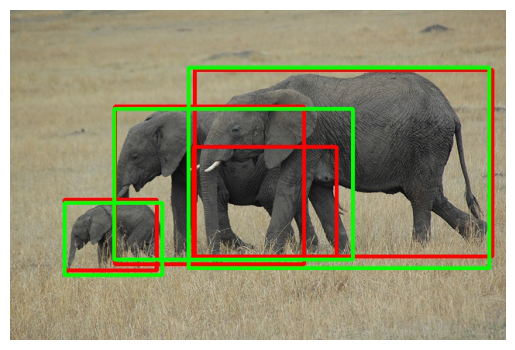

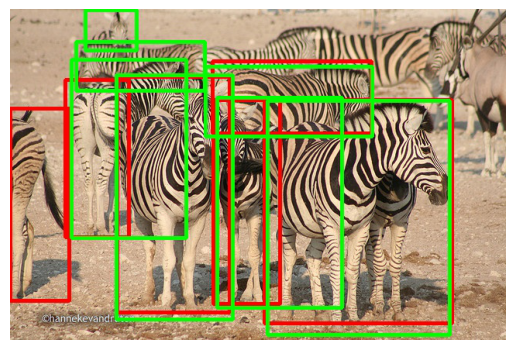

In [21]:
import os
# 폴더 생성
os.makedirs('/content/output', exist_ok=True)
# 디
def boxPlot(boxlist, imagePath, savePath):
    labelfiles = sorted(list(set([filename for filename, _, _, _ in boxlist])))
    
    for labelfile in labelfiles:
    
        rectinfos = []
        imgfilePath = os.path.join(imagePath, str(labelfile) + ".jpg")
        img = cv.imread(imgfilePath)

        for filename, _, conf, (x1, y1, x2, y2) in boxlist:
            if labelfile == filename:
                rectinfos.append((x1, y1, x2, y2, conf))
                
        for x1, y1, x2, y2, conf in rectinfos:
            
            if conf == 1.0:
                rectcolor = (0, 255, 0)
            else:
                rectcolor = (0, 0, 255)
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv.rectangle(img, (x1, y1), (x2, y2), rectcolor, 4)
        cv.imwrite(f"{savePath}/{labelfile}.jpg", img)

        img = mpimg.imread(f"{savePath}/{labelfile}.jpg")
        plt.axis("off")
        plt.imshow(img)
        plt.show()
        
# boxPlot(detections, "image", savePath="boxed_images/detection")
# boxPlot(groundtruths, "image", savePath="boxed_images/groundtruth")
boxPlot(predictions[:10] + ground_truths[:10], "/content/drive/MyDrive/dataset/test", savePath="/content/output")

In [22]:
def getArea(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)


def getUnionAreas(boxA, boxB, interArea=None):
    area_A = getArea(boxA)
    area_B = getArea(boxB)
    
    if interArea is None:
        interArea = getIntersectionArea(boxA, boxB)
        
    return float(area_A + area_B - interArea)

def getIntersectionArea(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # intersection area
    return (xB - xA + 1) * (yB - yA + 1)

In [23]:
def boxesIntersect(boxA, boxB):
    if boxA[0] > boxB[2]:
        return False  # boxA is right of boxB
    if boxB[0] > boxA[2]:
        return False  # boxA is left of boxB
    if boxA[3] < boxB[1]:
        return False  # boxA is above boxB
    if boxA[1] > boxB[3]:
        return False  # boxA is below boxB
    return True

def iou(boxA, boxB):
    # if boxes dont intersect
    if boxesIntersect(boxA, boxB) is False:
        return 0
    interArea = getIntersectionArea(boxA, boxB)
    union = getUnionAreas(boxA, boxB, interArea=interArea)
    
    # intersection over union
    result = interArea / union
    assert result >= 0
    return result

In [24]:
boxA = predictions[-1][-1]
boxB = ground_truths[-1][-1]

print(f"boxA coordinates : {(boxA)}")
print(f"boxA area : {getArea(boxA)}")
print(f"boxB coordinates : {(boxB)}")
print(f"boxB area : {getArea(boxB)}")

print(f"Union area of boxA and boxB : {getUnionAreas(boxA, boxB)}")

print(f"Does boxes Intersect? : {boxesIntersect(boxA, boxB)}")

print(f"Intersection area of boxA and boxB : {getIntersectionArea(boxA, boxB)}")

print(f"IoU of boxA and boxB : {iou(boxA, boxB)}")

boxA coordinates : [206.29351806640625, 189.74559020996094, 463.7039489746094, 316.744384765625]
boxA area : 33076.223656859715
boxB coordinates : [193, 190, 457, 318]
boxB area : 34185
Union area of boxA and boxB : 35107.13398073288
Does boxes Intersect? : True
Intersection area of boxA and boxB : 32154.089676126838
IoU of boxA and boxB : 0.9158847798220527


In [25]:
def calculateAveragePrecision(rec, prec):
    
    mrec = [0] + [e for e in rec] + [1]
    mpre = [0] + [e for e in prec] + [0]

    for i in range(len(mpre)-1, 0, -1):
        mpre[i-1] = max(mpre[i-1], mpre[i])

    ii = []

    for i in range(len(mrec)-1):
        if mrec[1:][i] != mrec[0:-1][i]:
            ii.append(i+1)

    ap = 0
    for i in ii:
        ap = ap + np.sum((mrec[i] - mrec[i-1]) * mpre[i])
    
    return [ap, mpre[0:len(mpre)-1], mrec[0:len(mpre)-1], ii]

In [26]:
def ElevenPointInterpolatedAP(rec, prec):

    mrec = [e for e in rec]
    mpre = [e for e in prec]

    recallValues = np.linspace(0, 1, 11)
    recallValues = list(recallValues[::-1])
    rhoInterp, recallValid = [], []

    for r in recallValues:
        argGreaterRecalls = np.argwhere(mrec[:] >= r)
        pmax = 0

        if argGreaterRecalls.size != 0:
            pmax = max(mpre[argGreaterRecalls.min():])

        recallValid.append(r)
        rhoInterp.append(pmax)

    ap = sum(rhoInterp) / 11

    return [ap, rhoInterp, recallValues, None]

In [27]:
def AP(detections, groundtruths, classes, IOUThreshold = 0.75, method = 'AP'):
    
    result = []
    
    for c in classes:

        dects = [d for d in detections if d[1] == c]
        gts = [g for g in groundtruths if g[1] == c]

        npos = len(gts)

        dects = sorted(dects, key = lambda conf : conf[2], reverse=True)

        TP = np.zeros(len(dects))
        FP = np.zeros(len(dects))

        det = Counter(cc[0] for cc in gts)

        # 각 이미지별 ground truth box의 수
        # {99 : 2, 380 : 4, ....}
        # {99 : [0, 0], 380 : [0, 0, 0, 0], ...}
        for key, val in det.items():
            det[key] = np.zeros(val)


        for d in range(len(dects)):


            gt = [gt for gt in gts if gt[0] == dects[d][0]]

            iouMax = 0

            for j in range(len(gt)):
                iou1 = iou(dects[d][3], gt[j][3])
                if iou1 > iouMax:
                    iouMax = iou1
                    jmax = j

            if iouMax >= IOUThreshold:
                if det[dects[d][0]][jmax] == 0:
                    TP[d] = 1
                    det[dects[d][0]][jmax] = 1
                else:
                    FP[d] = 1
            else:
                FP[d] = 1

        acc_FP = np.cumsum(FP)
        acc_TP = np.cumsum(TP)
        rec = acc_TP / npos
        prec = np.divide(acc_TP, (acc_FP + acc_TP))

        if method == "AP":
            [ap, mpre, mrec, ii] = calculateAveragePrecision(rec, prec)
        else:
            [ap, mpre, mrec, _] = ElevenPointInterpolatedAP(rec, prec)

        r = {
            'class' : c,
            'precision' : prec,
            'recall' : rec,
            'AP' : ap,
            'interpolated precision' : mpre,
            'interpolated recall' : mrec,
            'total positives' : npos,
            'total TP' : np.sum(TP),
            'total FP' : np.sum(FP)
        }

        result.append(r)

    return result

result = AP(predictions, ground_truths, classes)
print(result)

[{'class': 0, 'precision': array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.92857143, 0.93333333,
       0.9375    , 0.94117647, 0.94444444, 0.94736842, 0.95      ,
       0.95238095, 0.95454545, 0.95652174, 0.95833333, 0.96      ,
       0.96153846, 0.96296296, 0.96428571, 0.96551724, 0.96666667,
       0.96774194, 0.96875   , 0.96969697, 0.97058824, 0.97142857,
       0.97222222, 0.97297297, 0.97368421, 0.97435897, 0.975     ,
       0.97560976, 0.97619048, 0.97674419, 0.97727273, 0.97777778,
       0.97826087, 0.9787234 , 0.97916667, 0.97959184, 0.98      ,
       0.98039216, 0.98076923, 0.98113208, 0.98148148, 0.98181818,
       0.98214286, 0.98245614, 0.96551724, 0.96610169, 0.95      ,
       0.95081967, 0.9516129 , 0.95238095, 0.953125  , 0.95384615,
       0.95454545, 0.95522388, 0.95588235, 0.95652174, 0.94285714,
       0.94366197, 0.94444444, 0.94

In [28]:
def mAP(result):
    ap = 0
    for r in result:
        ap += r['AP']
    mAP = ap / len(result)
    
    return mAP

In [29]:
num2class = {"0" : "buffalo", "1" : "elephant", "2" : "rhino", "3" : "zebra"}

In [30]:
for r in result:
    print("{:^8} AP : {}".format(num2class[str(r['class'])], r['AP']))
print("---------------------------")
print(f"mAP : {mAP(result)}")


buffalo  AP : 0.7562506217807996
elephant AP : 0.8065580506986362
 rhino   AP : 0.9217895478606861
 zebra   AP : 0.7984663595287324
---------------------------
mAP : 0.8207661449672136
